In [1]:
from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import Aer, BasicAer
from qiskit.tools.monitor import job_monitor
import numpy as np
from scipy.optimize import minimize
from pylab import *
from Ising_n_exact import *
from math import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.quantumregister import AncillaQubit, AncillaRegister

In [2]:
bit = ['0','1']
dic = []
n = 6
def decToBin(k, n): 
    q1 = bin(k).replace("0b", "")
    q2 = '0'*(n-len(q1)) + q1
    q2 =q2[::-1]
    return q2
for k in range(0,2**n):
    dic.append(decToBin(k, n)[::-1])
#dic

In [13]:
# # h = float(input())
# g = float(input())
g = 1


In [36]:
psi = []
ran = 21
for j in range(1,ran):
    h = j/10
    haj = (np.array([g*h, g*h, g*h, g, g, g, 1, 0]))
    nor = np.sqrt(sum(haj[:]**2))
    psiS = haj/nor
    psi.append(psiS)



In [10]:
zz = QuantumCircuit(2)   
zz.z([0,1])
zz.to_gate()
c_zz = zz.control()
#c_zz?

In [38]:
param = [] # optimal parameter vector
n = 6
num_shot = 100000
for j in range(1, ran):
    
    q = QuantumRegister(n)
    c = ClassicalRegister(n)
    ancreg = AncillaRegister(1)

    anc = AncillaQubit(ancreg, 0)
    qc = QuantumCircuit(q, c, ancreg)

    qc.initialize(psi[j-1], [q[0],q[1],q[2]])
    qc.ry(np.pi/6, q[4])
    qc.ry(np.pi/6, q[3])
    qc.ry(np.pi/6, q[5])
    qc.cx(3, 4)
    qc.cx(4, 5)
    qc.cx(5, 3)
    qc.ry(np.pi/3, q[4])
    qc.ry(np.pi/3, q[3])
    qc.ry(np.pi/3, q[5])
    # qc.h([3, 4, 5])
    # qc.initialize(vec, [q[2], q[3]])
    qc.x([0, 1, 2])

    qc.mct([0, 1, 2], 3)

    qc.barrier()
    qc.x(0)
    qc.mct([0, 1, 2], 4)

    qc.barrier()
    qc.x([0, 1])
    qc.mct([0, 1, 2], 5)


    qc.barrier()
    qc.x(0)

    qc.mct([0, 1, 2], anc)
    qc.cz(anc, [3, 5])
    qc.mct([0, 1, 2], anc)
    qc.barrier()

    qc.x([0, 1, 2])
    qc.mct([0, 1, 2], anc)
    qc.cz(anc, [3, 4])
    qc.mct([0, 1, 2], anc)
    qc.barrier()

    qc.x(0)
    qc.mct([0, 1, 2], anc)
    qc.cz(anc, [4, 5])
    qc.mct([0, 1, 2], anc)
    qc.barrier()
    #
    qc.x([0, 1])
    qc.barrier()

    qc.x(0)
    qc.h([0, 1, 2])
    #     qc.initialize([1,0,0,0], [q[0],q[1]])
    qc.barrier()

    qc.measure(range(n), range(n))
#     qc.draw('mpl')
    shots = num_shot
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts()
    for i in dic:
        if i not in counts:
            counts[i] = 0
    #plot_histogram(counts)
    arr = np.array([counts['000000'], counts['001000'], counts['010000'],counts['011000'],counts['100000'],
                counts['101000'],counts['110000'],counts['111000']])

    # norm = np.linalg.1or0(arr),counts['1011000'],counts['1100000'],counts['1101000']
    normal = sum(arr[:])
    array = arr/normal
    new = np.array(list(np.sqrt(array[:])))
    ### descent
    
    k = 10
    for it in range(1, k):
        q = QuantumRegister(n)
        c = ClassicalRegister(n)
        ancreg = AncillaRegister(1)

        anc = AncillaQubit(ancreg, 0)
        qc = QuantumCircuit(q, c, ancreg)

        qc.initialize(psi[j-1], [q[0],q[1],q[2]])

        qc.initialize(new, [q[3], q[4], q[5]])
        qc.x([0, 1, 2])

        qc.mct([0, 1, 2], 3)

        qc.barrier()
        qc.x(0)
        qc.mct([0, 1, 2], 4)

        qc.barrier()
        qc.x([0, 1])
        qc.mct([0, 1, 2], 5)


        qc.barrier()
        qc.x(0)

        qc.mct([0, 1, 2], anc)
        qc.append(c_zz, [anc] + [i for i in [3, 5]])
        qc.mct([0, 1, 2], anc)
        qc.barrier()

        qc.x([0, 1, 2])
        qc.mct([0, 1, 2], anc)
        qc.append(c_zz, [anc] + [i for i in [3, 4]])
        qc.mct([0, 1, 2], anc)
        qc.barrier()

        qc.x(0)
        qc.mct([0, 1, 2], anc)
        qc.append(c_zz, [anc] + [i for i in [4, 5]])
        qc.mct([0, 1, 2], anc)
        qc.barrier()
        #
        qc.x([0, 1])
        qc.barrier()

        qc.x(0)
        qc.h([0, 1, 2])
        #     qc.initialize([1,0,0,0], [q[0],q[1]])
        qc.barrier()
        qc.measure(range(n), range(n))
        # shot
        shots = num_shot
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc, backend, shots=shots).result()
        counts = result.get_counts()
        for i in dic:
                if i not in counts:
                    counts[i] = 0

        # update x(t+1)
        arr = np.array([counts['000000'], counts['001000'], counts['010000'],counts['011000'],counts['100000'],
                    counts['101000'],counts['110000'],counts['111000']])

        normal = sum(arr[:])
        array = arr/normal
        new = np.array(list(np.sqrt(array[:])))
    param.append(new)
    

In [54]:
# optimal parameters optimized from quantum gradient descent 
copy = param.copy()
copy

[array([0.77280659, 0.01900791, 0.02327984, 0.01001805, 0.01900791,
        0.01847237, 0.0167634 , 0.6330741 ]),
 array([0.77424079, 0.04456385, 0.04174638, 0.03573057, 0.0429428 ,
        0.03338497, 0.03214806, 0.62574251]),
 array([0.76132241, 0.06117258, 0.06679607, 0.05806882, 0.06150777,
        0.05842182, 0.05912151, 0.63096809]),
 array([0.75773305, 0.08633437, 0.09174275, 0.08056374, 0.08449596,
        0.08108184, 0.07832359, 0.6193798 ]),
 array([0.73855026, 0.10954685, 0.11423085, 0.10217118, 0.1080724 ,
        0.10331628, 0.09951968, 0.6219303 ]),
 array([0.7286554 , 0.13143888, 0.13085967, 0.12255199, 0.13307988,
        0.12500678, 0.11886605, 0.61006213]),
 array([0.69908582, 0.15695955, 0.15689057, 0.14925342, 0.1552259 ,
        0.14318305, 0.14242506, 0.61226637]),
 array([0.68260887, 0.17492824, 0.17391855, 0.16428495, 0.17798481,
        0.1650203 , 0.16374806, 0.60040346]),
 array([0.66449908, 0.18974514, 0.19214448, 0.17957921, 0.19015693,
        0.18125148, 

In [41]:
fqe = []
for it in range(1, ran):
    h = it/10
    para = param[it-1]
    q1 = QuantumRegister(3)
    c1 = ClassicalRegister(3)
    qc1 = QuantumCircuit(q1,c1)
    qc1.initialize(para, [q1[0],q1[1],q1[2]])
    qc1.measure(range(3), range(3))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc1, backend, shots=shots).result()
    counts = result.get_counts()
    qc1.measure(range(3), range(3))
    # get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
    # Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count     
    for i in dic:
        if i not in counts:
            counts[i] = 0
    # function to calculate probability
    def prob(j):
        e = 0
        for i in counts.keys():
            if i[j] == i[(j+1)%3]:
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots

    # expectation value of energy estimation from counts
    E_J = -(prob(0) + prob(1) + prob(2))
    E_J
    q2 = QuantumRegister(3)
    c2 = ClassicalRegister(3)
    qc2 = QuantumCircuit(q2, c2)
    qc2.initialize(para, [q2[0], q2[1], q2[2]])
    qc2.h([0, 1, 2])
    qc2.measure(range(3),range(3))
    # Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc2, backend, shots=shots).result()
    counts = result.get_counts()

    # get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
    # Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count 

    for i in dic:
        if i not in counts:
            counts[i] = 0
    # function to calculate probability

    def prob(j):
        e2 = 0
        for i in counts.keys():
            if i[j] == '0':
                e2 += counts[i]
            else:
                e2 -= counts[i]
        return e2/shots 
    # expectation value estimation from counts

    E_Z = -(prob(0)+prob(1)+prob(2))
    
    e_avg = (E_J + h*E_Z)/3
    fqe.append(e_avg)
#     print('E_total mean is',(E_J + h*E_Z))

In [60]:
x_axis =[]
eminex = []
for it in range(1, ran):
    h = it/10
    Emin_exact,vec_Emin_exact=groundsate(n=3,h=h)
    eminex.append(Emin_exact/3)
    x_axis.append(h)


Text(0.5, 1.0, 'FQE vs Exact Diagonal')

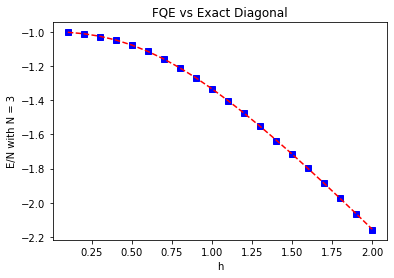

In [61]:
plot(x_axis,fqe,'bs', label='FQE')
plot(x_axis,eminex, 'r--',label='Exact')

plt.xlabel('h')
plt.ylabel('E/N with N = 3')
plt.title('FQE vs Exact Diagonal')